### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 24th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import scipy.stats as stats
import scipy 

1.1) Read in hw4_data_1.npy. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

In [2]:
data = np.load('hw_data_cp/hw4_data_1_NicholasHoward.npy')[0:,0]
noise = np.load('hw_data_cp/hw4_data_1_NicholasHoward.npy')[0:,1]

a = (data / (noise**2)).sum() #Numerator
b = ((noise**2)**(-1)).sum() #Denominator

sample_mean =  a / b #Divide after letting both sum first 
standard_error = (((noise**2)**(-1)).sum())**(-1/2)
print('Mean: ', sample_mean, '+/-', standard_error)

Mean:  4.942118214425304 +/- 0.43024334605205083


1.2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

In [4]:
def lnL(mu):
    ln_L =  0.5 * np.sum(((data - mu) / (noise))**2) #Find ln(Liklihood)
    return ln_L

fitf = lambda guess: lnL(mu=guess) # Fitting function 

guess0 = (69) #Initial guess

param = optimize.fmin(fitf,guess0)[0]
print('\nConverges to: ', param)

Optimization terminated successfully.
         Current function value: 2.807251
         Iterations: 24
         Function evaluations: 48

Converges to:  4.942108154296822


1.3) Compute and plot the Bayesian posterior probability density (not the log posterior) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

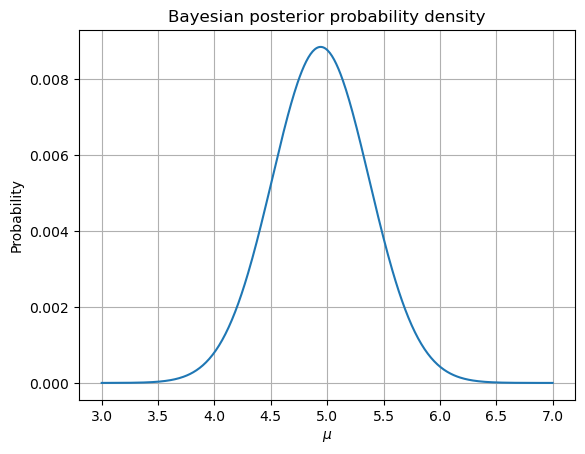

In [5]:
prior_mus = np.linspace(3,7,420) # Different initial values for means

def uni_prior(mu,prior): #Uniform Prior
    if prior[0] <= mu <= prior[-1]: #We know mean must be within these bounds so set this restriction 
        return 1 / (prior[-1] - prior[0])
    else:
        return 0

def likely(data,mu,std): #Likeihood function 
    L = (np.sqrt(2*np.pi) * std)**(-1) * np.exp(- (data - mu)**2 / (2 * std**2)) #Equation from Lecture 8 
    return np.prod(L)
    
def posterior(prior,std):
    Probs = []
    for mu in prior:
        Prior = uni_prior(mu,prior)
        Likelihood = likely(data=data,mu=mu,std=std)
        Probs.append(Prior * Likelihood) #Posterior distribution function 

    Probs = np.array(Probs) #alloes more functionality
    return Probs / Probs.sum() #Lazy normalization
    
Probs = posterior(prior_mus,noise)
plt.plot(prior_mus,Probs)
plt.xlabel('$\mu$')
plt.ylabel('Probability')
plt.title('Bayesian posterior probability density')
plt.grid()

1.4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. Also find the MAP value of the mean.

In [6]:
cdf = 0
Cdf = []
def find_cdf(posterior_distribution):
    cdf = 0
    Cdf = []
    for vals in posterior_distribution:
        cdf += vals #Sum every iteration of posterior distribution 
        Cdf.append(cdf) # Append every value of the sum above 
    return np.array(Cdf)
    
Cdf = find_cdf(Probs)

In [7]:
def find_1sig(Cdf,prior):
    hind = np.where(Cdf>=0.683)[0][0] # Find index at 68.3%
    lind = np.where(Cdf>=0.317)[0][0] # Find index at 31.7%
    val_683 = prior[hind] #Find where that value aligns with Voltage values 
    val_317 = prior[lind] #Find where that value aligns with Voltage values 
    return val_683,val_317

val_683, val_317 = find_1sig(Cdf,prior_mus)
print('At 68.3% we find a value of: ',val_683,
      '\nAt 31.7% we find a value of: ',val_317,
      'V\nCompare this to the inital values obtained: ',sample_mean, 'V +/-', standard_error,
      '\nThis is within the bounds')

At 68.3% we find a value of:  5.147971360381861 
At 31.7% we find a value of:  4.737470167064439 V
Compare this to the inital values obtained:  4.942118214425304 V +/- 0.43024334605205083 
This is within the bounds


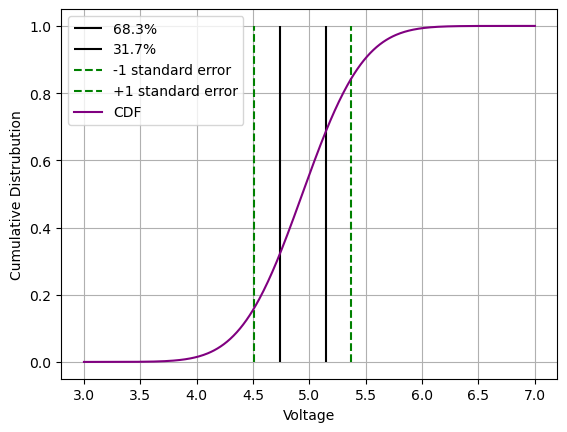

In [8]:
plt.vlines(val_683,0,1,color='black',label='68.3%') # 68.3% Verticle lines
plt.vlines(val_317,0,1,color='black',label='31.7%')
plt.vlines(sample_mean-standard_error,0,1,ls='--',color='green',label='-1 standard error')
plt.vlines(sample_mean+standard_error,0,1,ls='--',color='green',label='+1 standard error')
plt.plot(prior_mus,Cdf,label='CDF',color='purple')
plt.xlabel('Voltage')
plt.ylabel('Cumulative Distrubution')
plt.legend(loc='best')
plt.grid()
#These percentages are much closer to the MAP than what the standard error would yeild

In [9]:
def find_MAP(post_dist,prior):
    max_ind = np.where(post_dist==post_dist.max())[0][0] #Find index with highest posterior distrinbution value
    MAP = prior[max_ind] #Find where that value aligns with Voltage values 
    return MAP
    
MAP = find_MAP(Probs,prior_mus)
print('The MAP (Maximum A Posteriori) is simply the highest probability in the pdf for the voltage : ',MAP)

The MAP (Maximum A Posteriori) is simply the highest probability in the pdf for the voltage :  4.937947494033413


1.5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4.

In [10]:
# Just for myself I will re define all functions here 

def uni_prior(mu,prior): #Uniform Prior
    if prior[0] <= mu <= prior[-1]: #We know mean must be within these bounds so set this restriction 
        return 1 / (prior[-1] - prior[0])
    else:
        return 0

def likely(data,mu,std): #Likeihood function 
    L = (np.sqrt(2*np.pi) * std)**(-1) * np.exp(- (data - mu)**2 / (2 * std**2)) #Equation from Lecture 8 
    return np.prod(L)
    
def posterior(prior,std):
    Probs = []
    for mu in prior:
        Prior = uni_prior(mu,prior)
        Likelihood = likely(data=data,mu=mu,std=std)
        Probs.append(Prior * Likelihood) #Posterior distribution function 

    Probs = np.array(Probs) #alloes more functionality
    return Probs / Probs.sum() #Lazy normalization

def find_cdf(posterior_distribution):
    cdf = 0
    Cdf = []
    for vals in posterior_distribution:
        cdf += vals #Sum every iteration of posterior distribution 
        Cdf.append(cdf) # Append every value of the sum above 
    return np.array(Cdf)

def find_1sig(Cdf,prior):
    hind = np.where(Cdf>=0.683)[0][0] # Find index at 68.3%
    lind = np.where(Cdf>=0.317)[0][0] # Find index at 31.7%
    val_683 = prior[hind] #Find where that value aligns with Voltage values 
    val_317 = prior[lind] #Find where that value aligns with Voltage values 
    return val_683,val_317

def find_MAP(post_dist,prior):
    max_ind = np.where(post_dist==post_dist.max())[0][0] #Find index with highest posterior distrinbution value
    MAP = prior[max_ind] #Find where that value aligns with Voltage values 
    return MAP

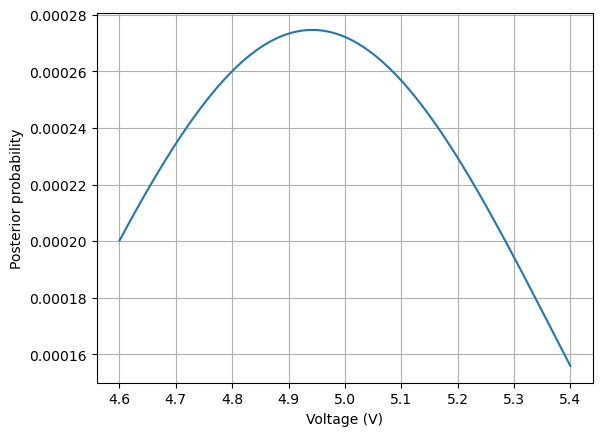

In [11]:
priors = np.linspace(4.6,5.4,4200) 
dist_Post = posterior(priors,noise)
plt.plot(priors,dist_Post)
plt.xlabel('Voltage (V)')
plt.ylabel('Posterior probability')
plt.grid()

In [12]:
dist_cdf = find_cdf(dist_Post)
sig1_h, sig1_l = find_1sig(dist_cdf,priors)
map = find_MAP(dist_Post,priors)
print('At 68.3% we find a value of: ',sig1_h,
      'V\nAt 31.7% we find a value of: ',sig1_l,
      'V\nCompare this to the inital values obtained: ',sample_mean, 'V +/-', standard_error,
      '\nThis is within the bounds')

At 68.3% we find a value of:  5.110788282924506 V
At 31.7% we find a value of:  4.852060014289116 V
Compare this to the inital values obtained:  4.942118214425304 V +/- 0.43024334605205083 
This is within the bounds


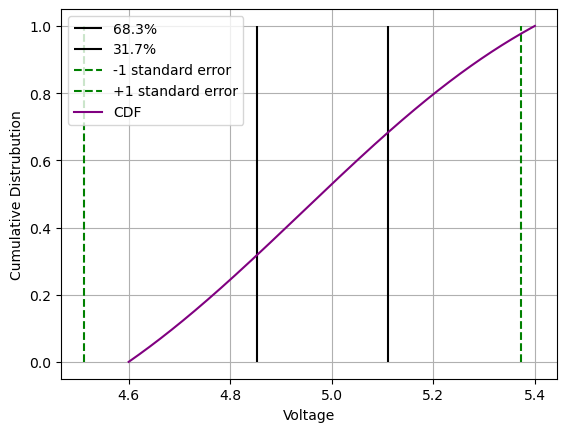

In [14]:
plt.vlines(sig1_h,0,1,color='black',label='68.3%') # 68.3% Verticle lines
plt.vlines(sig1_l,0,1,color='black',label='31.7%')
plt.vlines(sample_mean-standard_error,0,1,ls='--',color='green',label='-1 standard error')
plt.vlines(sample_mean+standard_error,0,1,ls='--',color='green',label='+1 standard error')
plt.plot(priors,dist_cdf,label='CDF',color='purple')
plt.xlabel('Voltage')
plt.ylabel('Cumulative Distrubution')
plt.legend(loc='best')
plt.grid()

In [15]:
map = find_MAP(dist_Post,priors)
print('The MAP (Maximum A Posteriori) is simply the highest probability in the pdf for the voltage : ',map)

The MAP (Maximum A Posteriori) is simply the highest probability in the pdf for the voltage :  4.942176708740176


1.6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually 6 $\pm$ 0.3
. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at 
 with standard deviation of $\pm$ 0.3
.

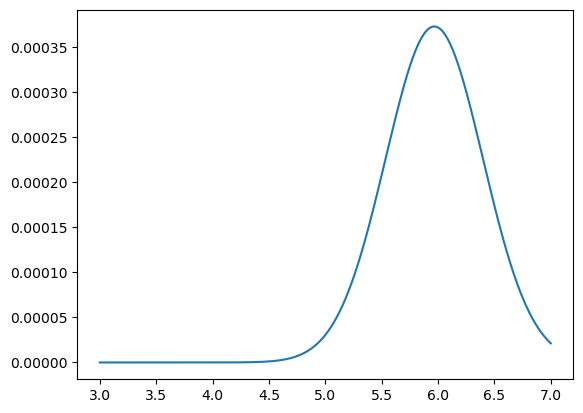

In [96]:
newpriors = np.linspace(start = 3,stop = 7, num = 10000)

def new_prior(mu): #This is the same problem just with a new prior
    if mu <= 6:
        return 1 / mu
    elif mu > 6: 
        return 1 - (mu-6) / 6

def new_liklihood(data,mu,std):
    return np.prod((np.sqrt(2*np.pi) * std)**(-1) * np.exp(-(data - mu)**2 / (2 * std**2)))

def new_posterior(data,mus,std):
    Post = []
    for mu in mus:
        Post.append(new_liklihood(data,mu,std) * new_prior(mu))
    Post = np.array(Post)
    return Post / Post.sum()
    
posti = new_posterior(data=data,
              mus=newpriors-(6-MAP),
              std=noise)

plt.plot(newpriors,posti)

#This confused me a bit but I think its just shifting the distriubution 

In [97]:
distcdf = find_cdf(posti)
sig1h, sig1l = find_1sig(distcdf,newpriors)
map = find_MAP(posti,newpriors)
print('At 68.3% we find a value of: ',sig1h,
      'V\nAt 31.7% we find a value of: ',sig1l,
      'V\nCompare this to the inital values obtained: ',sample_mean, 'V +/-', standard_error,
      '\nThis is within the bounds')

At 68.3% we find a value of:  6.165116511651165 V
At 31.7% we find a value of:  5.757475747574757 V
Compare this to the inital values obtained:  4.942118214425304 V +/- 0.43024334605205083 
This is within the bounds


1.7) Plot all of the normalized posterior pdfs for 
 from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

(0.0, 10.0)

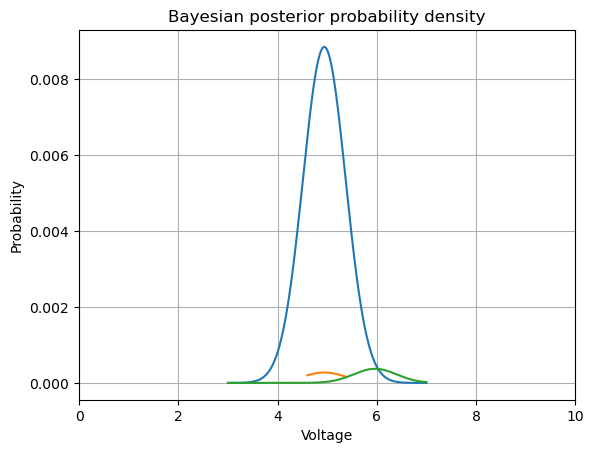

In [101]:
plt.plot(prior_mus,Probs)
plt.plot(priors,dist_Post)
plt.plot(newpriors,posti)
plt.xlabel('Voltage')
plt.ylabel('Probability')
plt.title('Bayesian posterior probability density')
plt.grid()
plt.xlim(0,10)

1.8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) (think about this and don't just immediately go looking for a scipy.stats delta function). Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly?

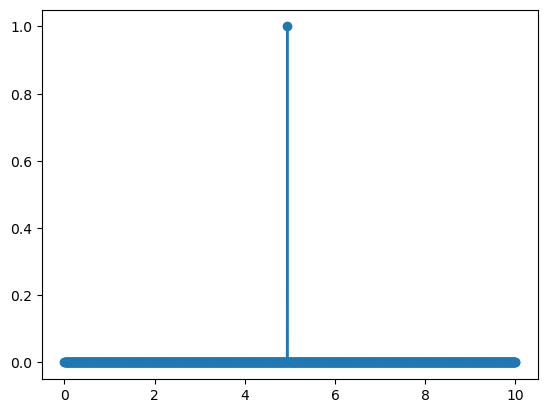

In [122]:
p_mus = np.linspace(0,10,1000)
def prior_delta(mu,value):
    if 4.94 <= mu <= 4.95:
        return 1
    else:
        return 0 
        
def delta_likelihood(data,std,mu):
    return np.prod((np.sqrt(2 * np.pi) * std)**(-1) * np.exp(-(data-mu)**2 / (2 * std**2)))

def delta_posterior(data,mu,std,value):
    Probs = []
    for mus in p_mus:
        Probs.append(prior_delta(mu=mus,value=value) * delta_likelihood(data=data,std=noise,mu=mus))
    Probs = np.array(Probs)
    return Probs / Probs.sum()

d_post = delta_posterior(data=data,
                         mu=p_mus,
                         std=noise,
                         value=4.942118214425304)
d_post[np.isnan(d_post)] = 0
plt.plot(p_mus,d_post,marker='o')

I would say the Bayesian model is more favored beacuse it allows other values to be investigated and is not overly trusting the data points

### Solution

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`

In [2]:
x,y,sigma_y = np.load('hw_data_cp/hw4_data_2_NicholasHoward.npy')
data =  np.load('hw_data_cp/hw4_data_2_NicholasHoward.npy')

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the 
-intercept is fixed. I advise a grid size of 100.

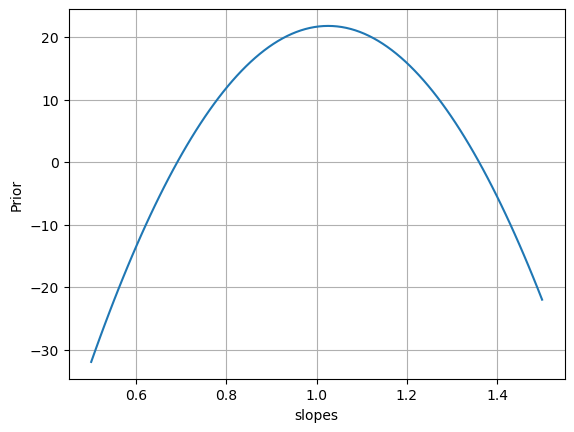

In [28]:
slopes = np.linspace(0.5,1.5,100)


# Theta = [y_int, slopes]

def prior_func(theta,scale,x):
    return stats.uniform.pdf(slopes,loc=slopes.min(),scale=slopes.max() - slopes.min()) # Uniform Prior 
    
def logL(theta, data, model):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))
    
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

def postior_func(slopes,y_int,x,scale):
    Prob = []
    for vals in slopes:
        theta = np.array([y_int,vals])
        prior = prior_func(theta,scale,x)
        #poly_fit = polynomial_fit(theta, x)
        lnL = (logL(theta, data, model=polynomial_fit))
        Prob.append((prior * lnL)[0])
    return np.array(Prob)

prior = postior_func(slopes=slopes,
                     y_int=-0.23,
                     x=x,
                     scale=sigma_y)

plt.plot(slopes, prior)
plt.ylabel('Prior')
plt.xlabel('slopes')
plt.grid()

2.3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

In [33]:
chi21 = np.sum(((y-polynomial_fit(slopes, x))/sigma_y)**2) 
print('x-prior of: ',chi21)

x-prior of:  2983.201243568276


4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the 
-intercept is fixed. I advise a grid size of 100 in each model dimension.

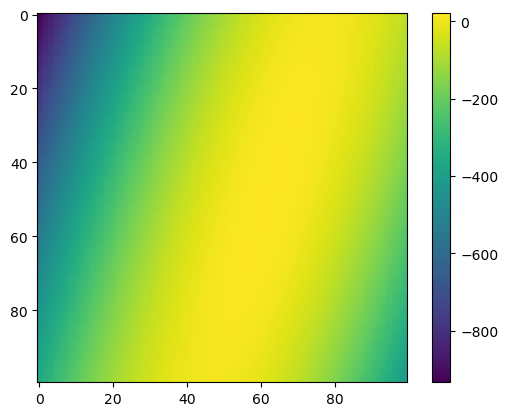

In [39]:
slopes = np.linspace(0.5,1.5,100)
yint = np.linspace(-1,0.25,100)

# Theta = [y_int, slopes]

def prior_func(theta,scale,x):
    return stats.uniform.pdf(slopes,loc=slopes.min(),scale=slopes.max() - slopes.min()) # Uniform Prior 
    
def logL(theta, data, model):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))
    
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

def postior_func(slopes,y_int,x,scale):
    Prob = []
    prob = []
    for vals in slopes:
        for yvals in y_int:
            theta = np.array([yvals,vals])
            prior = prior_func(theta,scale,x)
            lnL = (logL(theta, data, model=polynomial_fit))
            prob.append((prior * lnL)[0])
        Prob.append(np.array(prob))
        prob = []
    return Prob

prior = postior_func(slopes=slopes,
                     y_int=yint,
                     x=x,
                     scale=sigma_y)

plt.imshow(prior)
plt.colorbar()

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model.

In [42]:
chi22 = np.sum(((y-polynomial_fit(yint, x))/sigma_y)**2) 
print('x-prior of: ',chi22)

x-prior of:  14834.48057613191


6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

In [44]:
linear = chi21 / chi22

quadratic = chi22 / chi21

print('Linear Model: ', linear, '\nQuadratic Model: ', quadratic)

Linear Model:  0.20109913712571295 
Quadratic Model:  4.972671759276972


This is similar to what we seen in class beacuse the quadratic is prefered